<a href="https://colab.research.google.com/github/Franklnir/Analisis-Konsumsi-Listrik-Real-Time-Berbasis-Sensor-Menggunakan-PySpark-/blob/main/Kelompok2_UAS_BigData_Spark_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Analisis Big Data (UAS) — Pipeline Spark + Python + Dashboard (Dash)

**Topik:** Analisis Konsumsi Energi & Estimasi Tagihan Listrik Perangkat IoT (Time Series)  
**Dataset:** `"Supabase Snippet Device Energy and Billing Snapshot.csv"` (snapshot data monitoring & billing)  
**Luaran:** Notebook `.ipynb` (end-to-end), sesuai ketentuan UAS.

> **Catatan Reproducibility:** Jalankan notebook dari atas ke bawah (**Runtime → Run all**).  
> Notebook ini **fleksibel**: dataset bisa dibaca dari **Google Drive** *atau* di-*upload* ke **/content**.

## Checklist Ketentuan (mengacu pada PDF tugas)
Notebook ini memuat:
1. **Deskripsi dataset**
2. **Data ingestion & preprocessing**
3. **Pemrosesan menggunakan Apache Spark (PySpark)**
4. **Analisis lanjutan di Google Colab (Python)**
5. **Visualisasi data**
6. **Kode dashboard (Dash / alternatif Python dashboard)**

Selain itu:
- Bahasa: Indonesia formal akademik  
- Dashboard berbasis Python (Dash)  
- Notebook dapat dijalankan ulang (reproducible)

---

## 1) Deskripsi Dataset

Dataset berisi snapshot monitoring perangkat IoT terkait energi listrik dan estimasi biaya/tagihan.  
Struktur umum:
- **Identitas perangkat**: `device_id`
- **Waktu**: `ts` (timestamp), `tanggal`, `bulan`
- **Pengukuran listrik**: tegangan, arus, daya (aktif/semi/reaktif), frekuensi, faktor daya
- **Energi**: total kWh, harian, bulanan
- **Komponen biaya**: biaya energi, beban, PPJ, PBJT, total (harian/bulanan)
- **Parameter tarif**: nama tarif, harga/kWh, biaya beban, pajak

Di bawah ini dilakukan *profiling* awal untuk memahami ukuran data, kolom, tipe, dan contoh baris.

---

### 1.2) Konsep Big Data (5V) dan Justifikasi (Minimal 3V)

Walau dataset mentah ini relatif kecil (snapshot), tugas ini menilai pemahaman **karakteristik Big Data**.  
Agar memenuhi minimal **3 dari 5V**, notebook ini menggunakan:

- **Variety**: banyak atribut heterogen (pengukuran listrik + energi + komponen biaya + tarif).
- **Velocity**: data bersifat *time series* (timestamp berurutan) yang mencerminkan aliran data sensor/monitoring.
- **Value**: analisis menghasilkan insight praktis: jam puncak beban, estimasi biaya, potensi penghematan.
- (**Opsional untuk demonstrasi**) **Volume (simulasi ilmiah)**: untuk menunjukkan pemrosesan skala lebih besar di Spark, dilakukan *amplifikasi data* terkontrol (replikasi + pergeseran waktu + noise kecil).  
  Ini **sesuai ketentuan** karena dataset simulasi diperbolehkan dengan justifikasi ilmiah.

> Jika dosen meminta tanpa simulasi, kamu bisa mematikan fitur amplifikasi (lihat sel berikut).

---

## 2) Data Ingestion & Preprocessing
Pada bagian ini dilakukan setup environment, pemilihan sumber data (Drive / /content / ZIP), proses ingestion menggunakan Spark, dan preprocessing.


---

### 2.1) Setup Environment (Reproducible)

Sel ini:
- memasang dependensi (versi dipin untuk stabilitas),
- menyiapkan Java + Spark (Colab umumnya sudah mendukung),
- menyiapkan library dashboard.

Jika pernah menjalankan notebook ini sebelumnya, tetap aman dijalankan ulang.

In [6]:
# =========================
# 0) SETUP ENVIRONMENT
# =========================
!pip -q install pyspark==3.5.1 pandas==2.2.2 numpy==2.0.1 matplotlib==3.9.2 plotly==5.22.0 dash==2.17.1

import os, sys, math, json
import pandas as pd
import numpy as np

print("OK: dependensi terpasang.")


OK: dependensi terpasang.


---

### 2.2) Konfigurasi Path Dataset (Drive atau /content / ZIP)

**Rekomendasi saat notebook akan dikirim ke orang lain:**  
- Kirim notebook + dataset dalam **ZIP**, lalu penerima cukup upload ZIP ke Colab, extract ke `/content`, dan jalankan **Run all**.

Notebook ini mendukung 3 skenario:
1. **Google Drive**: dataset berada di `MyDrive/...`
2. **/content**: dataset diupload langsung melalui `files.upload()`
3. **ZIP**: penerima upload `dataset_bundle.zip` lalu di-*extract* otomatis (opsional)

> Kamu cukup set variabel di bawah sesuai kebutuhan.

In [7]:
# =========================
# 1) KONFIGURASI DATASET
# =========================
DATASET_FILENAME = "Supabase Snippet Device Energy and Billing Snapshot.csv"

# Opsi A (disarankan bila dataset ada di Google Drive kamu)
USE_GOOGLE_DRIVE = False
DRIVE_DATASET_PATH = f"/content/drive/MyDrive/UAS_BigData/{DATASET_FILENAME}"

# Opsi B (default saat notebook dikirim): dataset berada di /content (upload)
CONTENT_DATASET_PATH = f"/content/{DATASET_FILENAME}"

# Opsi C (opsional): jika kamu mengirim paket ZIP, upload ZIP ke Colab.
# - Jika kamu menamai ZIP sebagai "dataset_bundle.zip", cukup biarkan default ini.
# - Jika namanya berbeda, tidak masalah: notebook akan *auto-detect* ZIP yang berisi dataset CSV.
ZIP_BUNDLE_PATH = "/content/dataset_bundle.zip"

print("Konfigurasi siap.")

Konfigurasi siap.


In [8]:

# =========================
# 1A) MOUNT DRIVE (opsional)
# =========================
if USE_GOOGLE_DRIVE:
    from google.colab import drive
    drive.mount("/content/drive")
    print("Drive mounted:", DRIVE_DATASET_PATH)

In [9]:
# =========================
# 1B) EKSTRAK ZIP (opsional + auto-detect)
# =========================
import zipfile
import glob

def try_extract_zip(zip_path: str, target_csv: str) -> bool:
    try:
        with zipfile.ZipFile(zip_path, "r") as z:
            names = z.namelist()
            # hanya extract jika zip memuat CSV target (atau minimal ada file .csv)
            has_target = any(n.endswith(target_csv) or os.path.basename(n) == target_csv for n in names)
            has_any_csv = any(n.lower().endswith(".csv") for n in names)
            if not (has_target or has_any_csv):
                return False
            z.extractall("/content")
            print(f"ZIP diekstrak: {zip_path}")
            return True
    except Exception as e:
        print("Gagal ekstrak:", zip_path, "|", e)
        return False

extracted = False

# 1) Coba path default
if os.path.exists(ZIP_BUNDLE_PATH):
    extracted = try_extract_zip(ZIP_BUNDLE_PATH, DATASET_FILENAME)

# 2) Jika belum, auto-detect ZIP di /content yang berisi CSV
if not extracted:
    zips = sorted(glob.glob("/content/*.zip"))
    for zp in zips:
        if try_extract_zip(zp, DATASET_FILENAME):
            extracted = True
            break

if not extracted:
    print("Tidak ada ZIP yang perlu diekstrak (aman). Lanjut cek CSV...")

Tidak ada ZIP yang perlu diekstrak (aman). Lanjut cek CSV...


In [10]:
# =========================
# 1C) PASTIKAN CSV ADA (upload jika perlu)
# =========================
from google.colab import files
import os

def pick_csv_in_content(prefer_name: str | None = None) -> str | None:
    """Cari file CSV di /content. Jika ada beberapa, coba pilih yang paling relevan."""
    try:
        candidates = [f for f in os.listdir("/content") if f.lower().endswith(".csv")]
    except Exception:
        return None

    if not candidates:
        return None

    # 1) Jika ada yang persis sama dengan prefer_name
    if prefer_name and prefer_name in candidates:
        return f"/content/{prefer_name}"

    # 2) Prefer yang mengandung kata kunci (lebih mirip dataset kamu)
    keywords = ["supabase", "device", "energy", "billing", "snapshot"]
    scored = []
    for f in candidates:
        score = sum(1 for k in keywords if k in f.lower())
        scored.append((score, f))
    scored.sort(reverse=True)

    best_score, best_file = scored[0]
    # jika score 0 tapi hanya satu file, tetap pakai
    if best_score > 0 or len(candidates) == 1:
        return f"/content/{best_file}"

    # 3) Jika banyak dan tidak ada yang match, pakai yang paling baru (mtime terbesar)
    paths = [f"/content/{f}" for f in candidates]
    newest = max(paths, key=lambda p: os.path.getmtime(p))
    return newest

def ensure_dataset():
    # 1) Prioritas: Drive (jika aktif)
    if USE_GOOGLE_DRIVE and os.path.exists(DRIVE_DATASET_PATH):
        return DRIVE_DATASET_PATH

    # 2) /content: path default
    if os.path.exists(CONTENT_DATASET_PATH):
        return CONTENT_DATASET_PATH

    # 2b) /content: auto-detect CSV lain (misalnya ada "(3).csv")
    auto_csv = pick_csv_in_content(DATASET_FILENAME)
    if auto_csv:
        print("Dataset ditemukan via auto-detect:", os.path.basename(auto_csv))
        return auto_csv

    # 3) Upload manual
    print("Dataset belum ditemukan. Silakan upload file CSV sekarang...")
    uploaded = files.upload()
    if DATASET_FILENAME in uploaded:
        print("Upload sukses:", DATASET_FILENAME)
        return CONTENT_DATASET_PATH

    # Jika nama file berbeda, ambil yang pertama
    any_file = next(iter(uploaded.keys()))
    print("Nama file berbeda dari ekspektasi. Dipakai:", any_file)
    return f"/content/{any_file}"

DATASET_PATH = ensure_dataset()
print("DATASET_PATH =", DATASET_PATH)


Dataset belum ditemukan. Silakan upload file CSV sekarang...


Saving Supabase Snippet Device Energy and Billing Snapshot (2) - Salin.csv to Supabase Snippet Device Energy and Billing Snapshot (2) - Salin.csv
Nama file berbeda dari ekspektasi. Dipakai: Supabase Snippet Device Energy and Billing Snapshot (2) - Salin.csv
DATASET_PATH = /content/Supabase Snippet Device Energy and Billing Snapshot (2) - Salin.csv


In [11]:

import pandas as pd

df_raw_pd = pd.read_csv(DATASET_PATH)
print("Ukuran data (rows, cols):", df_raw_pd.shape)
display(df_raw_pd.head(5))
print("\nKolom:")
print(df_raw_pd.columns.tolist())

Ukuran data (rows, cols): (162283, 28)


,device_id,ts,tanggal,bulan,tegangan_v,arus_a,daya_aktif_w,daya_semu_va,daya_reaktif_var,frekuensi_hz,...,total_harian_rp,biaya_energi_bulanan_rp,beban_bulanan_rp,ppj_bulanan_rp,pbjt_bulanan_rp,total_bulanan_rp,nama_tarif,harga_per_kwh,biaya_beban,pajak_persen
0,ESP32-S3-Monitoring-01,2025-12-17 10:04:05+00,2025-12-17,2025-12-01 00:00:00+00,227.422,0.0634,6.582,14.426,12.792,49.991,...,324.67,3031.3,0.0,90.94,90.94,3213.18,PLN R1 1300VA Prabayar (simulasi),1438.0,0.0,6.0
1,ESP32-S3-Monitoring-01,2025-12-17 10:03:58+00,2025-12-17,2025-12-01 00:00:00+00,227.596,0.0709,7.843,16.133,14.099,49.989,...,324.67,3031.3,0.0,90.94,90.94,3213.18,PLN R1 1300VA Prabayar (simulasi),1438.0,0.0,6.0
2,ESP32-S3-Monitoring-01,2025-12-17 10:03:32+00,2025-12-17,2025-12-01 00:00:00+00,227.628,0.0708,7.857,16.127,14.083,49.985,...,324.67,3031.3,0.0,90.94,90.94,3213.18,PLN R1 1300VA Prabayar (simulasi),1438.0,0.0,6.0
3,ESP32-S3-Monitoring-01,2025-12-17 10:03:24+00,2025-12-17,2025-12-01 00:00:00+00,227.626,0.0709,7.843,16.141,14.107,49.980,...,324.67,3031.3,0.0,90.94,90.94,3213.18,PLN R1 1300VA Prabayar (simulasi),1438.0,0.0,6.0
4,ESP32-S3-Monitoring-01,2025-12-17 10:03:20+00,2025-12-17,2025-12-01 00:00:00+00,227.602,0.0709,7.857,16.132,14.089,49.973,...,324.67,3031.3,0.0,90.94,90.94,3213.18,PLN R1 1300VA Prabayar (simulasi),1438.0,0.0,6.0



Kolom:
['device_id', 'ts', 'tanggal', 'bulan', 'tegangan_v', 'arus_a', 'daya_aktif_w', 'daya_semu_va', 'daya_reaktif_var', 'frekuensi_hz', 'faktor_daya', 'energi_total_kwh', 'energi_harian_kwh', 'energi_bulanan_kwh', 'biaya_energi_harian_rp', 'beban_harian_rp', 'ppj_harian_rp', 'pbjt_harian_rp', 'total_harian_rp', 'biaya_energi_bulanan_rp', 'beban_bulanan_rp', 'ppj_bulanan_rp', 'pbjt_bulanan_rp', 'total_bulanan_rp', 'nama_tarif', 'harga_per_kwh', 'biaya_beban', 'pajak_persen']


In [12]:

# Statistik ringkas & missing values
missing = df_raw_pd.isna().sum().sort_values(ascending=False)
display(pd.DataFrame({"missing_count": missing, "missing_pct": (missing/len(df_raw_pd))*100}).head(20))
display(df_raw_pd.describe(include="all").transpose().head(20))

,missing_count,missing_pct
daya_reaktif_var,13832,8.523382
arus_a,13828,8.520917
tegangan_v,13828,8.520917
daya_aktif_w,13828,8.520917
daya_semu_va,13828,8.520917
frekuensi_hz,13828,8.520917
faktor_daya,13828,8.520917
nama_tarif,8182,5.041810
pajak_persen,8182,5.041810
biaya_beban,8182,5.041810


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
device_id,162283,1,ESP32-S3-Monitoring-01,162283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ts,162283,162283,2025-12-06 15:35:34+00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tanggal,162283,12,2025-12-08,23126,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bulan,162283,1,2025-12-01 00:00:00+00,162283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tegangan_v,148455.0,NaN,NaN,NaN,223.891271,4.277871,209.319,221.051,224.365,227.154,234.352
arus_a,148455.0,NaN,NaN,NaN,0.096578,0.087011,-0.0619,0.0398,0.0743,0.1187,0.5635
daya_aktif_w,148455.0,NaN,NaN,NaN,10.90029,11.010164,-13.976,2.909,8.474,13.64,68.89
daya_semu_va,148455.0,NaN,NaN,NaN,21.590681,19.454866,-13.976,8.9,16.526,26.617,125.908
daya_reaktif_var,148451.0,NaN,NaN,NaN,18.556734,16.132941,0.0,8.378,14.109,22.8565,105.507
frekuensi_hz,148455.0,NaN,NaN,NaN,49.985038,0.024882,49.888,49.979,49.999,50.0,50.075


---

### 2.3) Data Ingestion dengan PySpark

Pada tahap ini:
- Membuat **SparkSession**,
- Mendefinisikan **schema eksplisit** (reproducible),
- Membaca CSV ke Spark DataFrame.

Selanjutnya kita bisa memilih apakah akan memakai dataset asli atau dataset hasil simulasi Volume.

In [13]:

from pyspark.sql import SparkSession
from pyspark.sql.types import (
    StructType, StructField, StringType, DoubleType, TimestampType, DateType
)
from pyspark.sql import functions as F

spark = (
    SparkSession.builder
    .appName("UAS_BigData_Spark_Pipeline")
    .config("spark.sql.session.timeZone", "UTC")
    .getOrCreate()
)

spark

In [14]:

# Schema eksplisit (lebih reproducible daripada inferSchema)
schema = StructType([
    StructField("device_id", StringType(), True),
    StructField("ts", StringType(), True),          # parse ke timestamp setelah load
    StructField("tanggal", StringType(), True),     # parse ke date setelah load
    StructField("bulan", StringType(), True),       # parse ke timestamp/first-day setelah load

    StructField("tegangan_v", DoubleType(), True),
    StructField("arus_a", DoubleType(), True),
    StructField("daya_aktif_w", DoubleType(), True),
    StructField("daya_semu_va", DoubleType(), True),
    StructField("daya_reaktif_var", DoubleType(), True),
    StructField("frekuensi_hz", DoubleType(), True),
    StructField("faktor_daya", DoubleType(), True),
    StructField("energi_total_kwh", DoubleType(), True),
    StructField("energi_harian_kwh", DoubleType(), True),
    StructField("energi_bulanan_kwh", DoubleType(), True),

    StructField("biaya_energi_harian_rp", DoubleType(), True),
    StructField("beban_harian_rp", DoubleType(), True),
    StructField("ppj_harian_rp", DoubleType(), True),
    StructField("pbjt_harian_rp", DoubleType(), True),
    StructField("total_harian_rp", DoubleType(), True),

    StructField("biaya_energi_bulanan_rp", DoubleType(), True),
    StructField("beban_bulanan_rp", DoubleType(), True),
    StructField("ppj_bulanan_rp", DoubleType(), True),
    StructField("pbjt_bulanan_rp", DoubleType(), True),
    StructField("total_bulanan_rp", DoubleType(), True),

    StructField("nama_tarif", StringType(), True),
    StructField("harga_per_kwh", DoubleType(), True),
    StructField("biaya_beban", DoubleType(), True),
    StructField("pajak_persen", DoubleType(), True),
])

df_raw = (
    spark.read
    .option("header", True)
    .schema(schema)
    .csv(DATASET_PATH)
)

print("Rows:", df_raw.count(), "Cols:", len(df_raw.columns))
df_raw.show(5, truncate=False)

Rows: 162283 Cols: 28
+----------------------+----------------------+----------+----------------------+----------+------+------------+------------+----------------+------------+-----------+----------------+-----------------+------------------+----------------------+---------------+-------------+--------------+---------------+-----------------------+----------------+--------------+---------------+----------------+---------------------------------+-------------+-----------+------------+
|device_id             |ts                    |tanggal   |bulan                 |tegangan_v|arus_a|daya_aktif_w|daya_semu_va|daya_reaktif_var|frekuensi_hz|faktor_daya|energi_total_kwh|energi_harian_kwh|energi_bulanan_kwh|biaya_energi_harian_rp|beban_harian_rp|ppj_harian_rp|pbjt_harian_rp|total_harian_rp|biaya_energi_bulanan_rp|beban_bulanan_rp|ppj_bulanan_rp|pbjt_bulanan_rp|total_bulanan_rp|nama_tarif                       |harga_per_kwh|biaya_beban|pajak_persen|
+----------------------+------------------

---

### 2.4) Preprocessing (Spark)

Tahap preprocessing meliputi:
- Parsing `ts` menjadi `timestamp` (UTC),
- Parsing `tanggal` menjadi `date`,
- Normalisasi/derivasi fitur waktu (`jam`, `hari`, `bulan_key`),
- Pembersihan nilai tidak valid (misalnya negatif pada daya/energi),
- Penanganan missing values sederhana (imputasi median untuk numerik),
- Penghapusan duplikasi (berdasarkan `device_id` + `ts`).

In [15]:

# Parse waktu
df = (
    df_raw
    .withColumn("ts_ts", F.to_timestamp("ts"))                # ts berformat 'YYYY-MM-DD HH:MM:SS+00'
    .withColumn("tanggal_date", F.to_date("tanggal"))
    .withColumn("bulan_ts", F.to_timestamp("bulan"))
    .drop("ts", "tanggal", "bulan")
    .withColumnRenamed("ts_ts", "ts")
    .withColumnRenamed("tanggal_date", "tanggal")
    .withColumnRenamed("bulan_ts", "bulan")
)

# Fitur waktu
df = (
    df
    .withColumn("jam", F.hour("ts"))
    .withColumn("hari", F.date_format("tanggal", "E"))  # Mon/Tue... (UTC)
    .withColumn("bulan_key", F.date_format("bulan", "yyyy-MM"))
)

# Hilangkan nilai negatif pada kolom tertentu (jika ada)
nonneg_cols = [
    "tegangan_v","arus_a","daya_aktif_w","daya_semu_va","daya_reaktif_var",
    "frekuensi_hz","faktor_daya","energi_total_kwh","energi_harian_kwh","energi_bulanan_kwh",
    "biaya_energi_harian_rp","beban_harian_rp","ppj_harian_rp","pbjt_harian_rp","total_harian_rp",
    "biaya_energi_bulanan_rp","beban_bulanan_rp","ppj_bulanan_rp","pbjt_bulanan_rp","total_bulanan_rp",
    "harga_per_kwh","biaya_beban","pajak_persen"
]
for c in nonneg_cols:
    df = df.withColumn(c, F.when(F.col(c) < 0, None).otherwise(F.col(c)))

# Deduplikasi (device_id + ts)
before = df.count()
df = df.dropDuplicates(["device_id","ts"])
after = df.count()
print("Deduplikasi:", before, "→", after, "(hapus", before-after, "baris)")

df.printSchema()
df.show(5, truncate=False)

Deduplikasi: 162283 → 162283 (hapus 0 baris)
root
 |-- device_id: string (nullable = true)
 |-- tegangan_v: double (nullable = true)
 |-- arus_a: double (nullable = true)
 |-- daya_aktif_w: double (nullable = true)
 |-- daya_semu_va: double (nullable = true)
 |-- daya_reaktif_var: double (nullable = true)
 |-- frekuensi_hz: double (nullable = true)
 |-- faktor_daya: double (nullable = true)
 |-- energi_total_kwh: double (nullable = true)
 |-- energi_harian_kwh: double (nullable = true)
 |-- energi_bulanan_kwh: double (nullable = true)
 |-- biaya_energi_harian_rp: double (nullable = true)
 |-- beban_harian_rp: double (nullable = true)
 |-- ppj_harian_rp: double (nullable = true)
 |-- pbjt_harian_rp: double (nullable = true)
 |-- total_harian_rp: double (nullable = true)
 |-- biaya_energi_bulanan_rp: double (nullable = true)
 |-- beban_bulanan_rp: double (nullable = true)
 |-- ppj_bulanan_rp: double (nullable = true)
 |-- pbjt_bulanan_rp: double (nullable = true)
 |-- total_bulanan_rp: d

In [16]:

# Imputasi median untuk numerik (sederhana, reproducible)
numeric_cols = [c for c, t in df.dtypes if t in ("double", "int", "bigint")]

medians = {}
for c in numeric_cols:
    med = df.approxQuantile(c, [0.5], 0.01)[0]  # median approximate
    medians[c] = med

# fillna hanya untuk kolom numerik
df_clean = df.fillna(medians)

print("Contoh median yang dipakai (5 kolom pertama):")
print(dict(list(medians.items())[:5]))

print("Missing setelah imputasi (total):")
missing_total = sum(df_clean.filter(F.col(c).isNull()).count() for c in df_clean.columns)
print(missing_total)

Contoh median yang dipakai (5 kolom pertama):
{'tegangan_v': 224.33, 'arus_a': 0.074, 'daya_aktif_w': 8.457, 'daya_semu_va': 16.43, 'daya_reaktif_var': 14.022}
Missing setelah imputasi (total):
0


---

## 3) Pemrosesan Menggunakan Apache Spark (PySpark)
Bagian ini fokus pada pemrosesan skala besar menggunakan Spark: simulasi volume (opsional) dan analisis/agregasi utama.


---

### 3.1) (Opsional) Simulasi Volume untuk Demonstrasi Spark

Karena dataset asli kecil, kita dapat melakukan **amplifikasi** untuk menunjukkan pemrosesan data lebih besar menggunakan Spark.
Metode:
- mereplikasi baris dataset beberapa kali,
- menggeser timestamp agar tetap realistis sebagai *streaming-like time series*,
- menambahkan noise kecil pada beberapa pengukuran (opsional).

> Simulasi ini untuk **demonstrasi teknis Spark** dan pembahasan 5V.  
> Jika ingin murni dataset asli, set `USE_SIMULATED_VOLUME = False`.

In [17]:

USE_SIMULATED_VOLUME = True
AMPLIFY_FACTOR = 200   # 1000 rows × 200 = 200.000 rows (cukup untuk demo, tidak terlalu berat)

np.random.seed(42)

base = df_clean

if USE_SIMULATED_VOLUME:
    # Buat range untuk replikasi
    reps = spark.range(0, AMPLIFY_FACTOR).withColumnRenamed("id", "rep_id")
    df_big = (
        base.crossJoin(reps)
        # geser timestamp tiap replikasi (aman: tambah detik berbasis epoch)
        .withColumn("ts", F.to_timestamp(F.from_unixtime(F.col("ts").cast("long") + F.col("rep_id"))))
        # noise kecil (±1%) pada daya_aktif_w dan arus
        .withColumn("daya_aktif_w", F.col("daya_aktif_w") * (1 + (F.rand(seed=1)-0.5)/50))
        .withColumn("arus_a", F.col("arus_a") * (1 + (F.rand(seed=2)-0.5)/50))
        .drop("rep_id")
    )
    df_use = df_big.cache()
    print("Menggunakan data SIMULASI. Rows:", df_use.count())
else:
    df_use = base.cache()
    print("Menggunakan data ASLI. Rows:", df_use.count())

Menggunakan data SIMULASI. Rows: 32456600


---

### 3.2) Pemrosesan & Analisis dengan Spark (PySpark)

Contoh pemrosesan skala besar yang umum pada kasus monitoring energi:
1. Agregasi **harian**: energi & biaya per perangkat per tanggal
2. Agregasi **per jam**: identifikasi jam puncak beban (peak hour)
3. Deteksi **anomali**: lonjakan daya atau biaya di luar pola umum
4. Ringkasan tarif & pajak untuk interpretasi komponen biaya

In [18]:

# 7.1 Agregasi harian (energi & biaya)
daily = (
    df_use.groupBy("device_id", "tanggal")
    .agg(
        F.count("*").alias("n_record"),
        F.avg("daya_aktif_w").alias("avg_daya_w"),
        F.max("daya_aktif_w").alias("max_daya_w"),
        F.sum("energi_harian_kwh").alias("sum_energi_harian_kwh"),
        F.avg("total_harian_rp").alias("avg_total_harian_rp"),
        F.max("total_harian_rp").alias("max_total_harian_rp"),
    )
    .orderBy("device_id", "tanggal")
)

daily.show(10, truncate=False)

+----------------------+----------+--------+------------------+------------------+---------------------+-------------------+-------------------+
|device_id             |tanggal   |n_record|avg_daya_w        |max_daya_w        |sum_energi_harian_kwh|avg_total_harian_rp|max_total_harian_rp|
+----------------------+----------+--------+------------------+------------------+---------------------+-------------------+-------------------+
|ESP32-S3-Monitoring-01|2025-12-06|1102200 |5.054151519306593 |46.19445604852001 |4723.600000000096    |80.78999999999405  |80.79              |
|ESP32-S3-Monitoring-01|2025-12-07|1512800 |14.024900371731366|59.47457813609585 |56515.93599999851    |51.08073638286584  |109.75             |
|ESP32-S3-Monitoring-01|2025-12-08|4625200 |8.227118740385409 |63.36168715145423 |34020.73799999963    |11.211893972152602 |74.69              |
|ESP32-S3-Monitoring-01|2025-12-09|3240200 |7.894506571543373 |59.830422647969066|142144.4059999958    |66.86881427072534  |221.02

In [19]:

# 7.2 Agregasi per jam (peak hour)
hourly = (
    df_use.groupBy("device_id", "tanggal", "jam")
    .agg(
        F.avg("daya_aktif_w").alias("avg_daya_w"),
        F.sum("energi_harian_kwh").alias("sum_energi_harian_kwh"),
        F.avg("total_harian_rp").alias("avg_total_harian_rp"),
    )
)

# Cari jam puncak (berdasarkan P95 daya per device)
peak = (
    hourly.groupBy("device_id")
    .agg(F.expr("percentile_approx(avg_daya_w, 0.95)").alias("p95_daya_w"))
    .join(hourly, on="device_id", how="inner")
    .where(F.col("avg_daya_w") >= F.col("p95_daya_w"))
    .groupBy("device_id")
    .agg(
        F.first("jam").alias("contoh_jam_peak"),
        F.max("avg_daya_w").alias("max_avg_daya_w")
    )
)

peak.show(truncate=False)

+----------------------+---------------+-----------------+
|device_id             |contoh_jam_peak|max_avg_daya_w   |
+----------------------+---------------+-----------------+
|ESP32-S3-Monitoring-01|12             |39.76441142153909|
+----------------------+---------------+-----------------+



In [20]:

# 7.3 Deteksi anomali sederhana (Z-score pada avg_daya_w per device)
from pyspark.sql.window import Window

w = Window.partitionBy("device_id")
hourly_z = (
    hourly
    .withColumn("mu", F.avg("avg_daya_w").over(w))
    .withColumn("sigma", F.stddev("avg_daya_w").over(w))
    .withColumn("z", (F.col("avg_daya_w") - F.col("mu")) / F.col("sigma"))
)

anomali = hourly_z.where(F.col("z") > 3).orderBy(F.desc("z"))
anomali.show(20, truncate=False)

+----------------------+----------+---+------------------+---------------------+-------------------+------------------+-----------------+------------------+
|device_id             |tanggal   |jam|avg_daya_w        |sum_energi_harian_kwh|avg_total_harian_rp|mu                |sigma            |z                 |
+----------------------+----------+---+------------------+---------------------+-------------------+------------------+-----------------+------------------+
|ESP32-S3-Monitoring-01|2025-12-11|2  |39.76441142153909 |13651.06799999998    |160.30865947611704 |11.170297737229882|8.873539932633618|3.2224020967269857|
|ESP32-S3-Monitoring-01|2025-12-13|13 |39.33752489596434 |29995.534000000018   |326.58252857142776 |11.170297737229882|8.873539932633618|3.1742942920835637|
|ESP32-S3-Monitoring-01|2025-12-11|15 |38.564836492730194|49907.80000000008    |552.0571698113215  |11.170297737229882|8.873539932633618|3.087216484455462 |
+----------------------+----------+---+------------------+

In [21]:

# 7.4 Ringkasan tarif & pajak
tarif = (
    df_use.groupBy("device_id", "nama_tarif", "harga_per_kwh", "biaya_beban", "pajak_persen")
    .agg(F.count("*").alias("n"))
    .orderBy(F.desc("n"))
)
tarif.show(truncate=False)

+----------------------+---------------------------------+-------------+-----------+------------+--------+
|device_id             |nama_tarif                       |harga_per_kwh|biaya_beban|pajak_persen|n       |
+----------------------+---------------------------------+-------------+-----------+------------+--------+
|ESP32-S3-Monitoring-01|PLN R1 1300VA Prabayar (simulasi)|1438.0       |0.0        |6.0         |30820200|
|ESP32-S3-Monitoring-01|null                             |1438.0       |0.0        |6.0         |1636400 |
+----------------------+---------------------------------+-------------+-----------+------------+--------+



---

## 4) Analisis Lanjutan di Google Colab (Python)

Pada tahap ini, hasil agregasi Spark dikonversi ke Pandas untuk analisis lanjutan yang lebih fleksibel, misalnya:
- perbandingan biaya harian,
- korelasi variabel listrik,
- ringkasan KPI untuk dashboard.

In [22]:

daily_pd = daily.toPandas()
hourly_pd = hourly.toPandas()

print("daily_pd:", daily_pd.shape, "hourly_pd:", hourly_pd.shape)
display(daily_pd.head())

daily_pd: (12, 8) hourly_pd: (249, 6)


,device_id,tanggal,n_record,avg_daya_w,max_daya_w,sum_energi_harian_kwh,avg_total_harian_rp,max_total_harian_rp
0,ESP32-S3-Monitoring-01,2025-12-06,1102200,5.054152,46.194456,4723.600,80.790000,80.79
1,ESP32-S3-Monitoring-01,2025-12-07,1512800,14.024900,59.474578,56515.936,51.080736,109.75
2,ESP32-S3-Monitoring-01,2025-12-08,4625200,8.227119,63.361687,34020.738,11.211894,74.69
3,ESP32-S3-Monitoring-01,2025-12-09,3240200,7.894507,59.830423,142144.406,66.868814,221.02
4,ESP32-S3-Monitoring-01,2025-12-10,3169200,8.123254,37.143877,153908.670,74.025258,135.66


In [23]:

# KPI dasar
kpi = {
    "jumlah_device": int(daily_pd["device_id"].nunique()),
    "hari_tercakup": int(daily_pd["tanggal"].nunique()),
    "rata2_daya_w": float(daily_pd["avg_daya_w"].mean()),
    "maks_daya_w": float(daily_pd["max_daya_w"].max()),
    "rata2_total_harian_rp": float(daily_pd["avg_total_harian_rp"].mean()),
    "maks_total_harian_rp": float(daily_pd["max_total_harian_rp"].max()),
}
kpi

{'jumlah_device': 1,
 'hari_tercakup': 12,
 'rata2_daya_w': 10.921183600471416,
 'maks_daya_w': 69.57779972570995,
 'rata2_total_harian_rp': 135.525623995521,
 'maks_total_harian_rp': 603.61}

---

## 5) Visualisasi Data (Python)

Visualisasi dibuat untuk mendukung interpretasi:
- Tren biaya harian,
- Pola beban per jam (heatmap sederhana),
- Hubungan daya vs biaya.

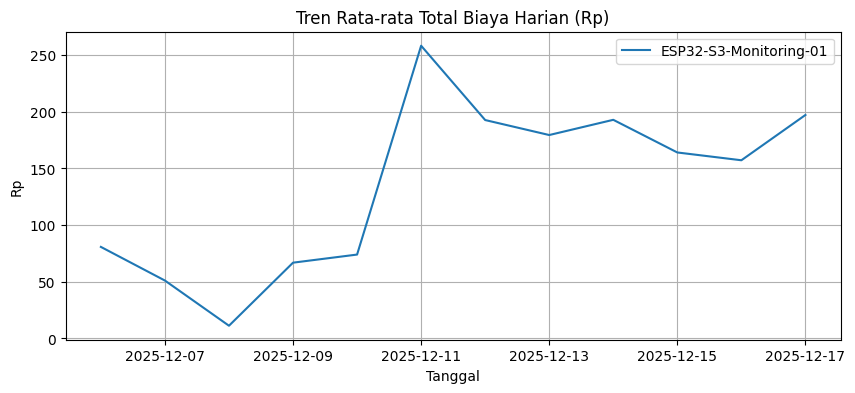

In [24]:

import matplotlib.pyplot as plt

# Tren biaya harian per device
plt.figure(figsize=(10,4))
for device, g in daily_pd.groupby("device_id"):
    g = g.sort_values("tanggal")
    plt.plot(pd.to_datetime(g["tanggal"]), g["avg_total_harian_rp"], label=device)
plt.title("Tren Rata-rata Total Biaya Harian (Rp)")
plt.xlabel("Tanggal")
plt.ylabel("Rp")
plt.legend()
plt.grid(True)
plt.show()

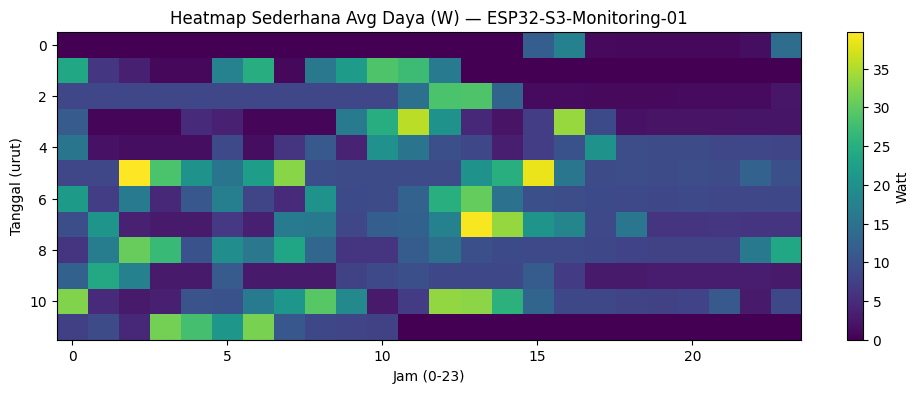

In [25]:

# Pola beban rata-rata per jam (sederhana)
# pilih satu device jika banyak
device0 = hourly_pd["device_id"].iloc[0]
h = hourly_pd[hourly_pd["device_id"]==device0].copy()
pivot = h.pivot_table(index="tanggal", columns="jam", values="avg_daya_w", aggfunc="mean").sort_index()

plt.figure(figsize=(12,4))
plt.imshow(pivot.fillna(0).values, aspect="auto")
plt.title(f"Heatmap Sederhana Avg Daya (W) — {device0}")
plt.xlabel("Jam (0-23)")
plt.ylabel("Tanggal (urut)")
plt.colorbar(label="Watt")
plt.show()

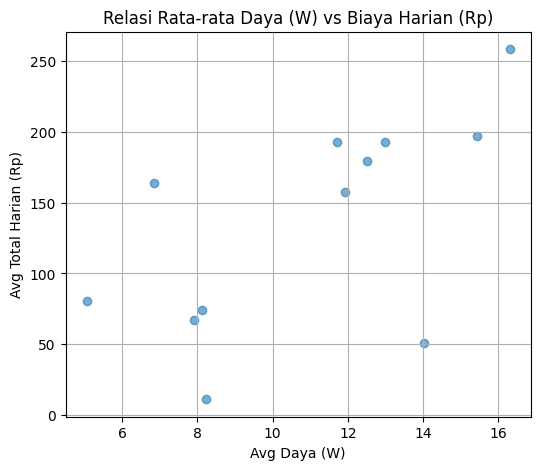

In [26]:

# Scatter daya vs biaya (indikasi hubungan)
plt.figure(figsize=(6,5))
plt.scatter(daily_pd["avg_daya_w"], daily_pd["avg_total_harian_rp"], alpha=0.6)
plt.title("Relasi Rata-rata Daya (W) vs Biaya Harian (Rp)")
plt.xlabel("Avg Daya (W)")
plt.ylabel("Avg Total Harian (Rp)")
plt.grid(True)
plt.show()

---
## Tambahan Analisis (Untuk Memperkuat Penilaian)
Bagian ini menambahkan:
1) **Korelasi numerik (Pearson)** antar-variabel utama  
2) **Outlier/Anomali berbasis IQR** pada data mentah (daya & arus)  
3) **Validasi energi–biaya**: hitung `expected_total_harian_rp` lalu bandingkan dengan `total_harian_rp`  


Kolom korelasi: ['tegangan_v', 'arus_a', 'daya_aktif_w', 'daya_semu_va', 'daya_reaktif_var', 'frekuensi_hz', 'faktor_daya', 'energi_total_kwh', 'energi_harian_kwh', 'energi_bulanan_kwh', 'total_harian_rp', 'total_bulanan_rp', 'harga_per_kwh', 'pajak_persen', 'biaya_beban']
Rows untuk korelasi: 50000 dari total: 32456600


,tegangan_v,arus_a,daya_aktif_w,daya_semu_va,daya_reaktif_var,frekuensi_hz,faktor_daya,energi_total_kwh,energi_harian_kwh,energi_bulanan_kwh,total_harian_rp,total_bulanan_rp,harga_per_kwh,pajak_persen,biaya_beban
tegangan_v,1.000000,-0.087287,-0.082645,-0.065047,-0.059302,-0.009697,-0.229233,-0.078667,-0.166876,-0.064518,-0.159306,-0.039795,NaN,NaN,NaN
arus_a,-0.087287,1.000000,0.997743,0.999532,0.998820,-0.003479,0.590458,0.089496,0.302558,0.077106,0.298140,0.061808,NaN,NaN,NaN
daya_aktif_w,-0.082645,0.997743,1.000000,0.997733,0.995444,-0.000334,0.608304,0.071219,0.288325,0.057332,0.283945,0.042199,NaN,NaN,NaN
daya_semu_va,-0.065047,0.999532,0.997733,1.000000,0.999484,-0.004741,0.588325,0.090477,0.297977,0.078027,0.293586,0.063152,NaN,NaN,NaN
daya_reaktif_var,-0.059302,0.998820,0.995444,0.999484,1.000000,-0.006363,0.581594,0.098937,0.302560,0.086928,0.298136,0.072115,NaN,NaN,NaN
frekuensi_hz,-0.009697,-0.003479,-0.000334,-0.004741,-0.006363,1.000000,0.060985,-0.125867,-0.006543,-0.137667,-0.008108,-0.142717,NaN,NaN,NaN
faktor_daya,-0.229233,0.590458,0.608304,0.588325,0.581594,0.060985,1.000000,0.210542,0.290999,0.178341,0.268199,0.131794,NaN,NaN,NaN
energi_total_kwh,-0.078667,0.089496,0.071219,0.090477,0.098937,-0.125867,0.210542,1.000000,0.358285,0.910346,0.345299,0.888741,NaN,NaN,NaN
energi_harian_kwh,-0.166876,0.302558,0.288325,0.297977,0.302560,-0.006543,0.290999,0.358285,1.000000,0.334535,0.994637,0.314550,NaN,NaN,NaN
energi_bulanan_kwh,-0.064518,0.077106,0.057332,0.078027,0.086928,-0.137667,0.178341,0.910346,0.334535,1.000000,0.321351,0.985856,NaN,NaN,NaN


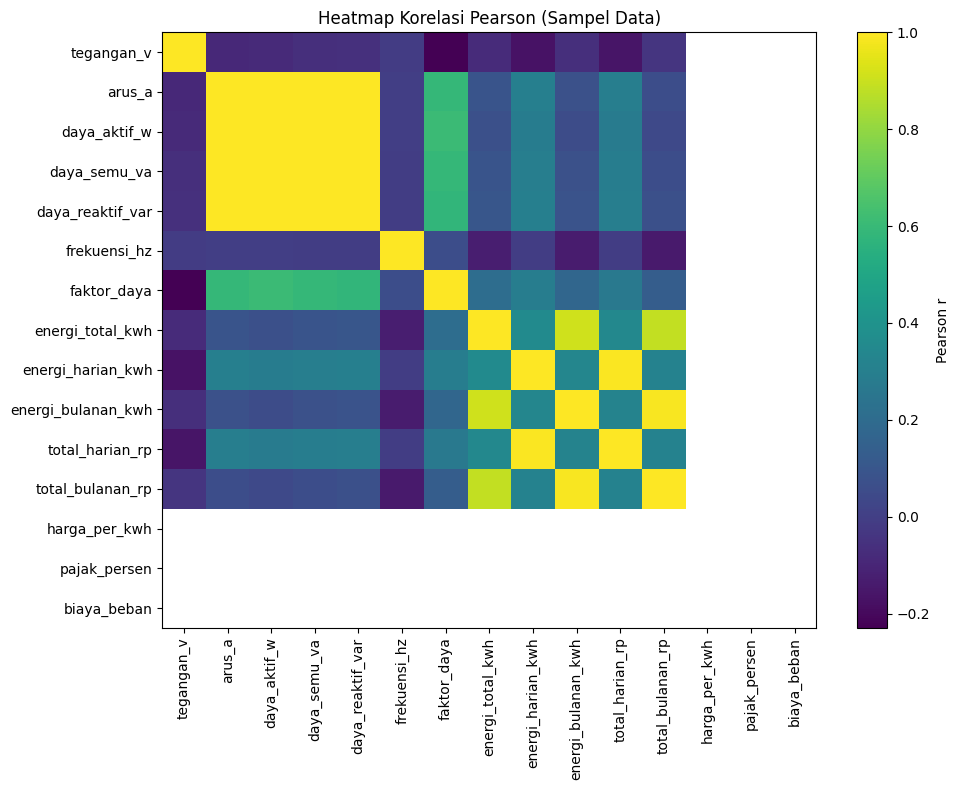

Pearson(arus_a, daya_aktif_w) = 0.9977
Pearson(daya_aktif_w, total_harian_rp) = 0.2839


In [27]:

# ============================================================
# A) Korelasi Numerik (Pearson) — Sampel dari df_use
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pilih kolom numerik yang umum ada pada dataset ini
candidate_cols = [
    "tegangan_v","arus_a","daya_aktif_w","daya_semu_va","daya_reaktif_var",
    "frekuensi_hz","faktor_daya",
    "energi_total_kwh","energi_harian_kwh","energi_bulanan_kwh",
    "total_harian_rp","total_bulanan_rp","harga_per_kwh","pajak_persen","biaya_beban"
]

# Ambil yang benar-benar ada
cols = [c for c in candidate_cols if c in df_use.columns]
print("Kolom korelasi:", cols)

# Agar ringan, ambil sampel maksimal N baris (aman untuk data amplifikasi besar)
N = 50000
df_corr_spark = df_use.select(cols).dropna()
n_total = df_corr_spark.count()
take_n = min(N, n_total)
print("Rows untuk korelasi:", take_n, "dari total:", n_total)

# Ambil sample acak bila data besar, kalau kecil ambil semua
if n_total > take_n:
    pdf_corr = df_corr_spark.sample(False, take_n / n_total, seed=42).toPandas()
else:
    pdf_corr = df_corr_spark.toPandas()

corr = pdf_corr.corr(numeric_only=True, method="pearson")
display(corr)

# Heatmap korelasi (tanpa seaborn agar ringan & kompatibel)
plt.figure(figsize=(10,8))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(label="Pearson r")
plt.title("Heatmap Korelasi Pearson (Sampel Data)")
plt.tight_layout()
plt.show()

# Contoh highlight korelasi yang sering dipakai (kalau kolom ada)
def show_pair(a,b):
    if a in corr.columns and b in corr.columns:
        print(f"Pearson({a}, {b}) = {corr.loc[a,b]:.4f}")

show_pair("arus_a","daya_aktif_w")
show_pair("daya_aktif_w","total_harian_rp")


In [28]:

# ============================================================
# B) Outlier Screening (IQR) — Data Mentah (daya_aktif_w, arus_a)
# ============================================================
from pyspark.sql import functions as F

def iqr_bounds(df, col, q1=0.25, q3=0.75):
    # approxQuantile cepat dan stabil
    qs = df.approxQuantile(col, [q1, q3], 0.001)
    if len(qs) != 2:
        return None
    Q1, Q3 = qs
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return Q1, Q3, IQR, lower, upper

for target in ["daya_aktif_w", "arus_a"]:
    if target not in df_use.columns:
        print(f"Skip: kolom '{target}' tidak ada.")
        continue

    df_nonnull = df_use.select("device_id","ts",target).where(F.col(target).isNotNull())
    b = iqr_bounds(df_nonnull, target)
    if b is None:
        print(f"Gagal hitung IQR untuk {target}")
        continue

    Q1, Q3, IQR, lower, upper = b
    print(f"\n[{target}] Q1={Q1:.6f} Q3={Q3:.6f} IQR={IQR:.6f} lower={lower:.6f} upper={upper:.6f}")

    out = df_nonnull.where((F.col(target) < lower) | (F.col(target) > upper))
    n_out = out.count()
    n_all = df_nonnull.count()
    print(f"Outlier {target}: {n_out} / {n_all} ({(n_out/n_all*100 if n_all else 0):.2f}%)")

    # Tampilkan contoh outlier (10 teratas paling jauh)
    out_example = out.withColumn("dist", F.when(F.col(target) < lower, lower - F.col(target)).otherwise(F.col(target) - upper)) \
                     .orderBy(F.desc("dist")) \
                     .drop("dist")
    out_example.show(10, truncate=False)



[daya_aktif_w] Q1=2.929409 Q3=10.693290 IQR=7.763880 lower=-8.716411 upper=22.339110
Outlier daya_aktif_w: 4540892 / 32456600 (13.99%)
+----------------------+-------------------+-----------------+
|device_id             |ts                 |daya_aktif_w     |
+----------------------+-------------------+-----------------+
|ESP32-S3-Monitoring-01|2025-12-17 03:19:52|69.57779972570995|
|ESP32-S3-Monitoring-01|2025-12-17 03:21:05|69.57176749564158|
|ESP32-S3-Monitoring-01|2025-12-17 03:22:29|69.569983047249  |
|ESP32-S3-Monitoring-01|2025-12-17 03:19:32|69.56778086442895|
|ESP32-S3-Monitoring-01|2025-12-17 03:19:33|69.56710973632539|
|ESP32-S3-Monitoring-01|2025-12-17 03:22:12|69.56009384132545|
|ESP32-S3-Monitoring-01|2025-12-17 03:22:22|69.5573690746582 |
|ESP32-S3-Monitoring-01|2025-12-17 03:22:32|69.55635434130238|
|ESP32-S3-Monitoring-01|2025-12-17 03:21:10|69.55305784059111|
|ESP32-S3-Monitoring-01|2025-12-17 03:21:42|69.54677949496293|
+----------------------+-------------------+-

In [29]:

# ============================================================
# C) Validasi Energi–Biaya (expected_total_harian_rp vs total_harian_rp)
# ============================================================
from pyspark.sql import functions as F

needed = ["energi_harian_kwh","harga_per_kwh","pajak_persen","total_harian_rp"]
missing = [c for c in needed if c not in df_use.columns]
if missing:
    print("Tidak bisa validasi karena kolom kurang:", missing)
else:
    # expected sederhana (sesuai rumus artikel):
    # Cost = E(kWh) * Tarif(Rp/kWh) * (1 + Pajak/100)
    expected = (
        F.col("energi_harian_kwh") * F.col("harga_per_kwh") * (1 + (F.col("pajak_persen")/100.0))
    )

    # Tambahkan biaya_beban jika kolom tersedia (opsional)
    if "biaya_beban" in df_use.columns:
        expected_plus = expected + F.col("biaya_beban")
        mode_note = "expected_plus_beban = expected + biaya_beban"
    else:
        expected_plus = expected
        mode_note = "expected_plus_beban = expected (tanpa biaya_beban)"

    df_val = (
        df_use
        .select("device_id","ts","energi_harian_kwh","harga_per_kwh","pajak_persen","total_harian_rp",
                F.round(expected, 2).alias("expected_total_harian_rp"),
                F.round(expected_plus, 2).alias("expected_plus_beban_rp"))
        .where(
            F.col("energi_harian_kwh").isNotNull() &
            F.col("harga_per_kwh").isNotNull() &
            F.col("pajak_persen").isNotNull() &
            F.col("total_harian_rp").isNotNull()
        )
        .withColumn("abs_err_expected", F.abs(F.col("total_harian_rp") - F.col("expected_total_harian_rp")))
        .withColumn("abs_err_plus_beban", F.abs(F.col("total_harian_rp") - F.col("expected_plus_beban_rp")))
    )

    print("Mode:", mode_note)
    df_val.select(
        F.count("*").alias("n"),
        F.round(F.avg("abs_err_expected"), 3).alias("mae_expected"),
        F.round(F.max("abs_err_expected"), 3).alias("max_err_expected"),
        F.round(F.avg("abs_err_plus_beban"), 3).alias("mae_plus_beban"),
        F.round(F.max("abs_err_plus_beban"), 3).alias("max_err_plus_beban"),
    ).show(truncate=False)

    # tampilkan contoh error terbesar (top 10)
    df_val.orderBy(F.desc("abs_err_plus_beban")).show(10, truncate=False)


Mode: expected_plus_beban = expected + biaya_beban
+--------+------------+----------------+--------------+------------------+
|n       |mae_expected|max_err_expected|mae_plus_beban|max_err_plus_beban|
+--------+------------+----------------+--------------+------------------+
|32456600|2.929       |80.79           |2.929         |80.79             |
+--------+------------+----------------+--------------+------------------+

+----------------------+-------------------+-----------------+-------------+------------+---------------+------------------------+----------------------+----------------+------------------+
|device_id             |ts                 |energi_harian_kwh|harga_per_kwh|pajak_persen|total_harian_rp|expected_total_harian_rp|expected_plus_beban_rp|abs_err_expected|abs_err_plus_beban|
+----------------------+-------------------+-----------------+-------------+------------+---------------+------------------------+----------------------+----------------+------------------+
|ES

---

## 6) Kode Dashboard (Dash / Alternatif Python Dashboard)

Dashboard ini memenuhi ketentuan: **dashboard wajib berbasis Python**.  
Fitur:
- Filter device dan rentang tanggal
- KPI ringkas
- Grafik tren biaya harian
- Grafik pola per jam

> Jika tampilan *inline* bermasalah, ubah `mode="external"`.

In [30]:
# ===== DASHBOARD (Dash in Jupyter) =====
from dash import Dash, dcc, html, Input, Output
import plotly.express as px
import pandas as pd

# pastikan daily_pd dan hourly_pd sudah ada
daily_pd2 = daily_pd.copy()
daily_pd2["tanggal"] = pd.to_datetime(daily_pd2["tanggal"])

hourly_pd2 = None
if "hourly_pd" in globals() and hourly_pd is not None:
    hourly_pd2 = hourly_pd.copy()
    hourly_pd2["tanggal"] = pd.to_datetime(hourly_pd2["tanggal"])
    if "jam" in hourly_pd2.columns:
        hourly_pd2["jam"] = hourly_pd2["jam"].astype(int)

devices = sorted(daily_pd2["device_id"].dropna().unique().tolist())
min_date = daily_pd2["tanggal"].min()
max_date = daily_pd2["tanggal"].max()

app = Dash(__name__)

app.layout = html.Div(
    [
        html.H2("Dashboard Analitik — Monitoring Energi & Biaya (IoT)"),

        html.Div(
            [
                html.Div(
                    [
                        html.Label("Device"),
                        dcc.Dropdown(
                            id="device",
                            options=[{"label": d, "value": d} for d in devices],
                            value=devices[0],
                            clearable=False,
                        ),
                    ],
                    style={"flex": "1", "minWidth": "240px"},
                ),
                html.Div(
                    [
                        html.Label("Rentang Tanggal"),
                        dcc.DatePickerRange(
                            id="date_range",
                            min_date_allowed=min_date,
                            max_date_allowed=max_date,
                            start_date=min_date,
                            end_date=max_date,
                            display_format="YYYY-MM-DD",
                        ),
                    ],
                    style={"flex": "2", "minWidth": "320px"},
                ),
            ],
            style={"display": "flex", "gap": "16px", "alignItems": "end", "flexWrap": "wrap"},
        ),

        html.Hr(),
        html.Div(id="kpi_box", style={"padding": "8px 0"}),

        html.Div(
            [dcc.Graph(id="trend_biaya"), dcc.Graph(id="trend_daya")],
            style={"display": "grid", "gridTemplateColumns": "1fr 1fr", "gap": "12px"},
        ),

        dcc.Graph(id="pola_per_jam"),
    ],
    style={"fontFamily": "Arial", "padding": "12px"},
)

@app.callback(
    Output("kpi_box", "children"),
    Output("trend_biaya", "figure"),
    Output("trend_daya", "figure"),
    Output("pola_per_jam", "figure"),
    Input("device", "value"),
    Input("date_range", "start_date"),
    Input("date_range", "end_date"),
)
def update(device, start_date, end_date):
    d = daily_pd2[daily_pd2["device_id"] == device].copy()
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)
    d = d[(d["tanggal"] >= start_dt) & (d["tanggal"] <= end_dt)].sort_values("tanggal")

    if d.empty:
        fig = px.line(title="Tidak ada data pada rentang ini")
        return html.Div("Tidak ada data pada rentang ini."), fig, fig, fig

    def safe_mean(col): return float(d[col].mean()) if col in d.columns else float("nan")
    def safe_max(col):  return float(d[col].max())  if col in d.columns else float("nan")

    kpi = html.Div([
        html.B("KPI Ringkas"),
        html.Ul([
            html.Li(f"Jumlah hari: {int(d['tanggal'].nunique())}"),
            html.Li(f"Rata-rata daya (W): {safe_mean('avg_daya_w'):.3f}"),
            html.Li(f"Maks daya (W): {safe_max('max_daya_w'):.3f}"),
            html.Li(f"Rata-rata biaya harian (Rp): {safe_mean('avg_total_harian_rp'):.3f}"),
            html.Li(f"Maks biaya harian (Rp): {safe_max('max_total_harian_rp'):.3f}"),
        ])
    ])

    fig_biaya = px.line(d, x="tanggal", y="avg_total_harian_rp", title="Tren Rata-rata Total Biaya Harian (Rp)")
    fig_daya  = px.line(d, x="tanggal", y="avg_daya_w", title="Tren Rata-rata Daya Aktif (W)")

    if hourly_pd2 is not None and {"device_id","tanggal","jam","avg_daya_w"}.issubset(hourly_pd2.columns):
        h = hourly_pd2[hourly_pd2["device_id"] == device].copy()
        h = h[(h["tanggal"] >= start_dt) & (h["tanggal"] <= end_dt)]
        if h.empty:
            fig_hour = px.line(title="Tidak ada data per jam pada rentang ini")
        else:
            h_agg = h.groupby("jam", as_index=False)["avg_daya_w"].mean().sort_values("jam")
            fig_hour = px.bar(h_agg, x="jam", y="avg_daya_w", title="Pola Beban Rata-rata per Jam")
            fig_hour.update_xaxes(dtick=1)
    else:
        fig_hour = px.line(title="Data per jam belum tersedia")

    return kpi, fig_biaya, fig_daya, fig_hour

# ✅ PENTING: pakai Dash native untuk Jupyter
app.run(jupyter_mode="inline", debug=False)


<IPython.core.display.Javascript object>

---

## Lampiran A) Ekspor Hasil (Opsional)

Agar mudah dikumpulkan/ditunjukkan saat presentasi, hasil agregasi dapat diekspor sebagai CSV.

In [31]:

OUT_DIR = "/content/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

daily_out = os.path.join(OUT_DIR, "daily_aggregation.csv")
hourly_out = os.path.join(OUT_DIR, "hourly_aggregation.csv")

daily_pd.to_csv(daily_out, index=False)
hourly_pd.to_csv(hourly_out, index=False)

print("Tersimpan:", daily_out, hourly_out)

Tersimpan: /content/outputs/daily_aggregation.csv /content/outputs/hourly_aggregation.csv


---

## Lampiran B) Referensi (IEEE)

1. Apache Spark Documentation — Structured APIs (DataFrame/Dataset)  
2. Zaharia et al., *Apache Spark: A Unified Engine for Big Data Processing*, Communications of the ACM.  
3. Plotly Dash Documentation (Python dashboard framework)  
4. Konsep 5V Big Data (Variety, Velocity, Volume, Veracity, Value) dari literatur Big Data umum

> Referensi ini untuk melengkapi ketentuan sitasi IEEE/APA pada tugas. Artikel ilmiah (.docx) tetap mengikuti template JPCS.